In [1]:
from threeML import *

from hawc_hal import HAL, HealpixConeROI

import os

os.environ['OMP_NUM_THREADS'] = "1"
os.environ['MKL_NUM_THREADS'] = "1"

%matplotlib notebook

10:05:30 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=185843;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=207877;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=398295;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=596684;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

/Users/omodei/miniconda3/envs/hawc_3.9/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


10:05:31 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=265179;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=682990;file:///Users/omodei/GRBWorkDir/MY_PYTHON_MODULES/gitrepository/astromodels/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

/Users/omodei/miniconda3/envs/hawc_3.9/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
ra_crab, dec_crab = 83.633083, 22.014500

roi = HealpixConeROI(3.0, 12.0, ra=ra_crab, dec=dec_crab)

hawc = HAL("HAWC", 
                  "/home/giacomov/science/hawc/data/maptree_1024.root", 
                  "/home/giacomov/science/hawc/data/response.root",
                  roi)

hawc.set_active_measurements(1, 9)

hawc.display()

Creating singleton for /home/giacomov/science/hawc/data/response.root
Region of Interest: 
--------------------

HealpixConeROI: Center (R.A., Dec) = (83.633, 22.015), data radius = 3.000 deg, model radius: 12.000 deg

Flat sky projection: 
----------------------

Width x height: 142 x 142 px
Pixel sizes: 0.17 deg

Response: 
----------

Response file: /home/giacomov/science/hawc/data/response.root
Number of dec bins: 106
Number of energy/nHit planes per dec bin_name: 10

Map Tree: 
----------



,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,964234222.0,9.640280e+08,1.000214,8627,28.28354
1,1,1024,RING,63464148.0,6.338158e+07,1.001303,8627,28.28354
2,2,1024,RING,20357059.0,2.029720e+07,1.002949,8627,28.28354
3,3,1024,RING,5589697.0,5.554641e+06,1.006311,8627,28.28354
4,4,1024,RING,719476.0,7.072707e+05,1.017257,8627,28.28354
5,5,1024,RING,162229.0,1.559630e+05,1.040176,8627,28.28354
6,6,1024,RING,30084.0,2.797803e+04,1.075272,8627,28.28354
7,7,1024,RING,17787.0,1.656240e+04,1.073938,8627,28.28354
8,8,1024,RING,4909.0,4.454568e+03,1.102015,8627,28.28354
9,9,1024,RING,6607.0,6.144495e+03,1.075271,8627,28.28354


This Map Tree contains 1017.288 transits in the first bin
Total data size: 1.38 Mb

Active energy/nHit planes: 
---------------------------

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [3]:
spectrum = Log_parabola()

source = PointSource("CrabNebula", ra=ra_crab, dec=dec_crab, spectral_shape=spectrum)

# NOTE: if you use units, you have to set up the values for the parameters
# AFTER you create the source, because during creation the function Log_parabola
# gets its units

source.position.ra.bounds = (ra_crab - 0.5, ra_crab + 0.5)
source.position.dec.bounds = (dec_crab - 0.5, dec_crab + 0.5)

spectrum.piv = 10 * u.TeV  # Pivot energy
spectrum.piv.fix = True

spectrum.K = 1e-14 / (u.TeV * u.cm**2 * u.s)  # norm (in 1/(keV cm2 s))
spectrum.K.bounds = (1e-25, 1e-19) # without units energies are in keV

spectrum.beta = 0  # log parabolic beta
spectrum.beta.bounds = (-4., 2.)

spectrum.alpha = -2.5  # log parabolic alpha (index)
spectrum.alpha.bounds = (-4., 2.)

model = Model(source)

data = DataList(hawc)

In [4]:
jl = JointLikelihood(model, data, verbose=False)

In [5]:
jl.set_minimizer("minuit")
#%lprun -f FlatSkyToHealpixTransform.__call__ 
#%lprun -f hawc.get_log_like _ = jl.fit(quiet=False)

%prun _ = jl.fit()

# 12 s

# CrabNebula.spectrum.main.Log_parabola.K	(1.044 +/- 0.017) x 10^-22	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.807 +/- 0.018	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.750 +/- 0.11) x 10^-1

Best fit values:




WARNING FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



,result,unit
parameter,,
CrabNebula.spectrum.main.Log_parabola.K,(1.044 -0.017 +0.018) x 10^-22,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.791 +/- 0.020,
CrabNebula.spectrum.main.Log_parabola.beta,(1.720 +/- 0.12) x 10^-1,



Correlation matrix:



1.00,-0.17,0.67
-0.17,1.00,-0.77
0.67,-0.77,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,20257.502536
total,20257.502536



Values of statistical measures:



,statistical measures
AIC,40521.005350
BIC,40549.100783


In [8]:
gf = GoodnessOfFit(jl)

In [7]:
%load_ext line_profiler

In [8]:
from hawc_hal.convolved_source import ConvolvedPointSource
from hawc_hal.response.response import HAWCResponse, ResponseBin
from hawc_hal.psf_fast import PSFWrapper

In [9]:
import cProfile
command = """gf.by_mc(100)"""
cProfile.runctx( command, globals(), locals(), filename="profiling.profile" )

#%lprun -f PSFWrapper.__init__ gof, param, likes = gf.by_mc(10)

In [8]:
#print(gof)
#likes.plot()

In [9]:
#param.loc[(slice(None), ['CrabNebula.spectrum.main.Log_parabola.alpha']), 'value'].plot()

In [10]:
%load_ext line_profiler

In [10]:
source.position.ra.free = True
source.position.dec.free = True

jl.set_minimizer("minuit")

command = """jl.fit()"""
cProfile.runctx( command, globals(), locals(), filename="freepos.profile" )


#best_fit, like_frame = jl.fit()

# CrabNebula.position.ra	(8.362 +/- 0.00026) x 10	deg
# CrabNebula.position.dec	(2.202 +/- 0.00024) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(9.970 +/- 0.17) x 10^-23	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.798 +/- 0.021	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.590 +/- 0.13) x 10^-1

Best fit values:



,result,unit
parameter,,
CrabNebula.position.ra,(8.371 +/- 0.00035) x 10,deg
CrabNebula.position.dec,(2.196 +/- 0.0004) x 10,deg
CrabNebula.spectrum.main.Log_parabola.K,(1.075 +/- 0.018) x 10^-22,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.795 +/- 0.019,
CrabNebula.spectrum.main.Log_parabola.beta,(1.780 +/- 0.12) x 10^-1,



Correlation matrix:



1.00,0.60,-0.04,-0.03,0.01
0.60,1.00,-0.05,-0.03,0.01
-0.04,-0.05,1.00,-0.17,0.67
-0.03,-0.03,-0.17,1.00,-0.77
0.01,0.01,0.67,-0.77,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
HAWC,19568.932327
total,19568.932327



Values of statistical measures:



,statistical measures
AIC,39147.865349
BIC,39194.690839


In [ ]:
_ = jl.get_errors()

# CrabNebula.position.ra	(8.36201 -0.00027 +0.00026) x 10	deg
# CrabNebula.position.dec	(2.20206 -0.00025 +0.00023) x 10	deg
# CrabNebula.spectrum.main.Log_parabola.K	(1.010 +/- 0.017) x 10^-22	1 / (cm2 keV s)
# CrabNebula.spectrum.main.Log_parabola.alpha	-2.797 +/- 0.019	
# CrabNebula.spectrum.main.Log_parabola.beta	(1.630 +/- 0.11) x 10^-1

 
*** Profile stats marshalled to file u'contour.profile'. 



WARNING UserWarning: No contour levels were found within the data range.



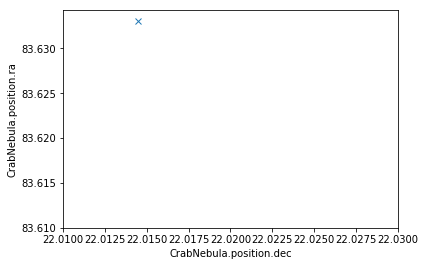

In [11]:
%prun -D contour.profile jl.get_contours(model.CrabNebula.position.ra, 83.610, 83.630, 16, model.CrabNebula.position.dec, 22.010, 22.030, 16)

import matplotlib.pyplot as plt

plt.plot([dec_crab], [ra_crab], 'x')

# Parallel: 183.5

# 225 / 225 in 249.2 s (0:00:00 remaining)

In [ ]:
print spectrum(1.0 * u.TeV).to(1/(u.TeV * u.cm**2 * u.s))

In [6]:
source.position.ra = ra_crab
source.position.ra.free = True

source.position.dec = dec_crab
source.position.dec.free = True

for parameter in model.parameters.values():
    
    if parameter.fix:
        
        continue
    
    if parameter.is_normalization:
    
        parameter.set_uninformative_prior(Log_uniform_prior)
    
    else:
        
        parameter.set_uninformative_prior(Uniform_prior)

bs = BayesianAnalysis(model, data)

%prun -D bayes.profile bs.sample(30, 10, 10)

# 71.3
# 38.3


WARNING RuntimeWarning: External parameter HAWC_bkg_renorm already exist in the model. Overwriting it...




Mean acceptance fraction: 0.37333333333333335

Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
CrabNebula.position.ra,(8.363 +/- 0.009) x 10,deg
CrabNebula.position.dec,(2.205 -0.009 +0.008) x 10,deg
CrabNebula.spectrum.main.Log_parabola.K,(1.00 -0.05 +0.04) x 10^-22,1 / (cm2 keV s)
CrabNebula.spectrum.main.Log_parabola.alpha,-2.85 -0.13 +0.12,
CrabNebula.spectrum.main.Log_parabola.beta,(1.76 -0.14 +0.09) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
HAWC,-19579.855146
total,-19579.855146



Values of statistical measures:



,statistical measures
AIC,39169.710987
BIC,39216.536478
DIC,46104.965950
PDIC,2373.982072


 
*** Profile stats marshalled to file u'bayes.profile'. 


In [ ]:
_ = bs.corner_plot()